# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../logs/comick/79_contexts/10-11-2022_19-39-04/oov_embedding_dict.pkl", "rb"))
oov_embeddings = {key: np.zeros((64), dtype=np.float32) for key, _ in oov_embeddings.items()}

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../logs/zero/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5036 | MulticlassF1Score=0.1287
Batch-30 : CrossEntropyLoss=2.4971 | MulticlassF1Score=0.1877
Batch-45 : CrossEntropyLoss=2.4726 | MulticlassF1Score=0.2078
Batch-60 : CrossEntropyLoss=2.4853 | MulticlassF1Score=0.2169
Batch-75 : CrossEntropyLoss=2.4536 | MulticlassF1Score=0.2293
Batch-90 : CrossEntropyLoss=2.4800 | MulticlassF1Score=0.2368
Batch-105: CrossEntropyLoss=2.4372 | MulticlassF1Score=0.2460
Batch-120: CrossEntropyLoss=2.4562 | MulticlassF1Score=0.2587
Batch-135: CrossEntropyLoss=2.4525 | MulticlassF1Score=0.2680
Batch-150: CrossEntropyLoss=2.4408 | MulticlassF1Score=0.2758
Batch-165: CrossEntropyLoss=2.4314 | MulticlassF1Score=0.2831
Batch-180: CrossEntropyLoss=2.4232 | MulticlassF1Score=0.2984
Batch-195: CrossEntropyLoss=2.3774 | MulticlassF1Score=0.3172
Batch-210: CrossEntropyLoss=2.3694 | MulticlassF1Score=0.3390
Batch-225: CrossEntropyLoss=2.3520 | MulticlassF1Score=0.3590
Batch-226: CrossEntropyLoss=2.3516 | MulticlassF1Score=0.3599

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3577 | MulticlassF1Score=0.6452
Batch-30 : CrossEntropyLoss=2.3650 | MulticlassF1Score=0.6456
Batch-45 : CrossEntropyLoss=2.3458 | MulticlassF1Score=0.6488
Batch-60 : CrossEntropyLoss=2.3590 | MulticlassF1Score=0.6495
Batch-63 : CrossEntropyLoss=2.3480 | MulticlassF1Score=0.6491

Training   : Mean CrossEntropyLoss = 2.4559 | Mean MulticlassF1Score = 0.2476
Validation : Mean CrossEntropyLoss = 2.3578 | Mean MulticlassF1Score = 0.6443

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3756 | MulticlassF1Score=0.6517
Batch-30 : CrossEntropyLoss=2.3662 | MulticlassF1Score=0.6528
Batch-45 : CrossEntropyLoss=2.3384 | MulticlassF1Score=0.6533
Batch-60 : CrossEntropyLoss=2.3461 | MulticlassF1Score=0.6611
Batch-75 : CrossEntropyLoss=2.3391 | MulticlassF1Score=0.6673
Batch-90 : CrossEntropyLoss=2.3320 | MulticlassF1Score=0.6727
Batch-105: CrossEntropyLoss=2.3305 | MulticlassF1Score=0.6766
Batch-120: CrossEntropyLoss=2.3515 | MulticlassF1Score=0.6780
Batch-135: CrossEntropyLoss=2.3210 | MulticlassF1Score=0.6797
Batch-150: CrossEntropyLoss=2.3419 | MulticlassF1Score=0.6823
Batch-165: CrossEntropyLoss=2.3575 | MulticlassF1Score=0.6831
Batch-180: CrossEntropyLoss=2.3374 | MulticlassF1Score=0.6846
Batch-195: CrossEntropyLoss=2.3326 | MulticlassF1Score=0.6870
Batch-210: CrossEntropyLoss=2.3260 | MulticlassF1Score=0.6911
Batch-225: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.6960
Batch-226: CrossEntropyLoss=2.3104 | MulticlassF1Score=0.6962

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.7600
Batch-30 : CrossEntropyLoss=2.3288 | MulticlassF1Score=0.7640
Batch-45 : CrossEntropyLoss=2.3205 | MulticlassF1Score=0.7661
Batch-60 : CrossEntropyLoss=2.3303 | MulticlassF1Score=0.7651
Batch-63 : CrossEntropyLoss=2.3282 | MulticlassF1Score=0.7645

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3430 | Mean MulticlassF1Score = 0.6728
Validation : Mean CrossEntropyLoss = 2.3216 | Mean MulticlassF1Score = 0.7625

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3212 | MulticlassF1Score=0.7684
Batch-30 : CrossEntropyLoss=2.3188 | MulticlassF1Score=0.7688
Batch-45 : CrossEntropyLoss=2.3169 | MulticlassF1Score=0.7681
Batch-60 : CrossEntropyLoss=2.3113 | MulticlassF1Score=0.7693
Batch-75 : CrossEntropyLoss=2.3216 | MulticlassF1Score=0.7695
Batch-90 : CrossEntropyLoss=2.3271 | MulticlassF1Score=0.7693
Batch-105: CrossEntropyLoss=2.3230 | MulticlassF1Score=0.7699
Batch-120: CrossEntropyLoss=2.3245 | MulticlassF1Score=0.7695
Batch-135: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7703
Batch-150: CrossEntropyLoss=2.3169 | MulticlassF1Score=0.7703
Batch-165: CrossEntropyLoss=2.3198 | MulticlassF1Score=0.7704
Batch-180: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.7703
Batch-195: CrossEntropyLoss=2.3120 | MulticlassF1Score=0.7708
Batch-210: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.7715
Batch-225: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7728
Batch-226: CrossEntropyLoss=2.3289 | MulticlassF1Score=0.7727

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3231 | MulticlassF1Score=0.7907
Batch-30 : CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7885
Batch-45 : CrossEntropyLoss=2.3180 | MulticlassF1Score=0.7887
Batch-60 : CrossEntropyLoss=2.3166 | MulticlassF1Score=0.7881
Batch-63 : CrossEntropyLoss=2.3088 | MulticlassF1Score=0.7883

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3188 | Mean MulticlassF1Score = 0.7698
Validation : Mean CrossEntropyLoss = 2.3137 | Mean MulticlassF1Score = 0.7890

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.7965
Batch-30 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.7915
Batch-45 : CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7928
Batch-60 : CrossEntropyLoss=2.3205 | MulticlassF1Score=0.7924
Batch-75 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.7921
Batch-90 : CrossEntropyLoss=2.3211 | MulticlassF1Score=0.7932
Batch-105: CrossEntropyLoss=2.3120 | MulticlassF1Score=0.7934
Batch-120: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.7937
Batch-135: CrossEntropyLoss=2.3154 | MulticlassF1Score=0.7949
Batch-150: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.7974
Batch-165: CrossEntropyLoss=2.3181 | MulticlassF1Score=0.7992
Batch-180: CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8014
Batch-195: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8033
Batch-210: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8049
Batch-225: CrossEntropyLoss=2.3141 | MulticlassF1Score=0.8061
Batch-226: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8063

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8204
Batch-30 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8207
Batch-45 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8222
Batch-60 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8232
Batch-63 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.8231

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3084 | Mean MulticlassF1Score = 0.7965
Validation : Mean CrossEntropyLoss = 2.3029 | Mean MulticlassF1Score = 0.8213

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8229
Batch-30 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8255
Batch-45 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8250
Batch-60 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8240
Batch-75 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8248
Batch-90 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8247
Batch-105: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8246
Batch-120: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8263
Batch-135: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8269
Batch-150: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8269
Batch-165: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8269
Batch-180: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8269
Batch-195: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8263
Batch-210: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8266
Batch-225: CrossEntropyLoss=2.3097 | MulticlassF1Score=0.8263
Batch-226: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8263

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8343
Batch-30 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8245
Batch-45 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8254
Batch-60 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8269
Batch-63 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8269

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3018 | Mean MulticlassF1Score = 0.8258
Validation : Mean CrossEntropyLoss = 2.3014 | Mean MulticlassF1Score = 0.8272

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8343
Batch-30 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8331
Batch-45 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8312
Batch-60 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8313
Batch-75 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8331
Batch-90 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8355
Batch-105: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8368
Batch-120: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8378
Batch-135: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8391
Batch-150: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8392
Batch-165: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8395
Batch-180: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8397
Batch-195: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8403
Batch-210: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8406
Batch-225: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8410
Batch-226: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8409

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8381
Batch-30 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8380
Batch-45 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8394
Batch-60 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8392
Batch-63 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8392

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2975 | Mean MulticlassF1Score = 0.8363
Validation : Mean CrossEntropyLoss = 2.2979 | Mean MulticlassF1Score = 0.8394

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8482
Batch-30 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8500
Batch-45 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8474
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8475
Batch-75 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8469
Batch-90 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8471
Batch-105: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8477
Batch-120: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8476
Batch-135: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8479
Batch-150: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8478
Batch-165: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8480
Batch-180: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8478
Batch-195: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8477
Batch-210: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8479
Batch-225: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8476
Batch-226: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8476

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8448
Batch-30 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8448
Batch-45 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8431
Batch-60 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8439
Batch-63 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8442

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2952 | Mean MulticlassF1Score = 0.8476
Validation : Mean CrossEntropyLoss = 2.2961 | Mean MulticlassF1Score = 0.8454

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8523
Batch-30 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8517
Batch-45 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8517
Batch-60 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8511
Batch-75 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8503
Batch-90 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8492
Batch-105: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8504
Batch-120: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8496
Batch-135: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8496
Batch-150: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8498
Batch-165: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8500
Batch-180: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8505
Batch-195: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8507
Batch-210: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8504
Batch-225: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8501
Batch-226: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8501

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8421
Batch-30 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8432
Batch-45 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8425
Batch-60 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8440
Batch-63 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8444

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2943 | Mean MulticlassF1Score = 0.8506
Validation : Mean CrossEntropyLoss = 2.2960 | Mean MulticlassF1Score = 0.8437

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8538
Batch-30 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8510
Batch-45 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8520
Batch-60 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8521
Batch-75 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8523
Batch-90 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8521
Batch-105: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8521
Batch-120: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8522
Batch-135: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8521
Batch-150: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8521
Batch-165: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8524
Batch-180: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8524
Batch-195: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8525
Batch-210: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8522
Batch-225: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8522
Batch-226: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8521

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8457
Batch-30 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8450
Batch-45 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8436
Batch-60 : CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8455
Batch-63 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8452

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2936 | Mean MulticlassF1Score = 0.8522
Validation : Mean CrossEntropyLoss = 2.2955 | Mean MulticlassF1Score = 0.8450

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8574
Batch-30 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8580
Batch-45 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8580
Batch-60 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8559
Batch-75 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8554
Batch-90 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8551
Batch-105: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8552
Batch-120: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8551
Batch-135: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8573
Batch-150: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8588
Batch-165: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8602
Batch-180: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8613
Batch-195: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8626
Batch-210: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8641
Batch-225: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8653
Batch-226: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8653

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8735
Batch-30 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8738
Batch-45 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8736
Batch-60 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8731
Batch-63 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8733

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2896 | Mean MulticlassF1Score = 0.8584
Validation : Mean CrossEntropyLoss = 2.2870 | Mean MulticlassF1Score = 0.8732

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8869
Batch-30 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8829
Batch-45 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8833
Batch-60 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8838
Batch-75 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8838
Batch-90 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8840
Batch-105: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8844
Batch-120: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8844
Batch-135: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8845
Batch-150: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8845
Batch-165: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8846
Batch-180: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8848
Batch-195: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8847
Batch-210: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8853
Batch-225: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8858
Batch-226: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8857

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8796
Batch-30 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8788
Batch-45 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8786
Batch-60 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8785
Batch-63 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8785

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8847
Validation : Mean CrossEntropyLoss = 2.2854 | Mean MulticlassF1Score = 0.8788

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8885
Batch-30 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8901
Batch-45 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8903
Batch-60 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8907
Batch-75 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8908
Batch-90 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8904
Batch-105: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8906
Batch-120: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8905
Batch-135: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8902
Batch-150: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8907
Batch-165: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8905
Batch-180: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8903
Batch-195: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8907
Batch-210: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8908
Batch-225: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8908
Batch-226: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8908

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8787
Batch-30 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8803
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8801
Batch-60 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8813
Batch-63 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8812

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8901
Validation : Mean CrossEntropyLoss = 2.2845 | Mean MulticlassF1Score = 0.8803

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.8954
Batch-30 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8936
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8942
Batch-60 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8944
Batch-75 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8937
Batch-90 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8941
Batch-105: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8942
Batch-120: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8939
Batch-135: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8940
Batch-150: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8937
Batch-165: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8935
Batch-180: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8937
Batch-195: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8939
Batch-210: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8939
Batch-225: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8937
Batch-226: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8937

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8794
Batch-30 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8820
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8806
Batch-60 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8807
Batch-63 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8804

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8939
Validation : Mean CrossEntropyLoss = 2.2846 | Mean MulticlassF1Score = 0.8803

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8973
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8960
Batch-45 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8969
Batch-60 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8961
Batch-75 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8953
Batch-90 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8951
Batch-105: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8955
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8956
Batch-135: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8959
Batch-150: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8955
Batch-165: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8956
Batch-180: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8957
Batch-195: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8956
Batch-210: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8955
Batch-225: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8955
Batch-226: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8955

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8819
Batch-30 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8815
Batch-45 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8815
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8824
Batch-63 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8820

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2801 | Mean MulticlassF1Score = 0.8961
Validation : Mean CrossEntropyLoss = 2.2843 | Mean MulticlassF1Score = 0.8815

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8970
Batch-30 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8986
Batch-45 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8985
Batch-60 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8981
Batch-75 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8991
Batch-90 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8985
Batch-105: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8983
Batch-120: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8986
Batch-135: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8985
Batch-150: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8982
Batch-165: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8985
Batch-180: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8985
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.8991
Batch-210: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9008
Batch-225: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9023
Batch-226: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.9023

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9099
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9115
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9104
Batch-60 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9089
Batch-63 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9084

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2781 | Mean MulticlassF1Score = 0.8986
Validation : Mean CrossEntropyLoss = 2.2761 | Mean MulticlassF1Score = 0.9094

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9259
Batch-45 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9278
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9266
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9261
Batch-90 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9259
Batch-105: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9262
Batch-120: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9258
Batch-135: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9258
Batch-150: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9259
Batch-165: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9260
Batch-180: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9261
Batch-195: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9261
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9263
Batch-225: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9263
Batch-226: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9263

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9096
Batch-30 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9082
Batch-45 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9089
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9100
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9104

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9262
Validation : Mean CrossEntropyLoss = 2.2755 | Mean MulticlassF1Score = 0.9107

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9230
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9277
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9285
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9283
Batch-90 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9283
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9285
Batch-120: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9289
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9291
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9288
Batch-165: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9286
Batch-180: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9281
Batch-195: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9283
Batch-210: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9283
Batch-225: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9281
Batch-226: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9281

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9086
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9100
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9100
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9102
Batch-63 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9106

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9277
Validation : Mean CrossEntropyLoss = 2.2754 | Mean MulticlassF1Score = 0.9098

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9269
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9293
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9295
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9312
Batch-75 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9312
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9318
Batch-105: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9309
Batch-120: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9306
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9303
Batch-150: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9305
Batch-165: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9305
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9303
Batch-195: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9299
Batch-210: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9297
Batch-225: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9294
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9294

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9135
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9121
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9109
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9110
Batch-63 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9108

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9299
Validation : Mean CrossEntropyLoss = 2.2754 | Mean MulticlassF1Score = 0.9123

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9304
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9314
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9307
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9297
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9296
Batch-90 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9293
Batch-105: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9292
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9297
Batch-135: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9299
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9300
Batch-165: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9299
Batch-180: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9302
Batch-195: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9304
Batch-210: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9304
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9302
Batch-226: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9303

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9083
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9104
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9113
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9112
Batch-63 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.9108

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2692 | Mean MulticlassF1Score = 0.9300
Validation : Mean CrossEntropyLoss = 2.2753 | Mean MulticlassF1Score = 0.9100

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9371
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9323
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9318
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9318
Batch-75 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9320
Batch-90 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9312
Batch-105: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9308
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9308
Batch-135: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9310
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9313
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9314
Batch-180: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9311
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9310
Batch-210: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9309
Batch-225: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9311
Batch-226: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9311

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9095
Batch-30 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9089
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9095
Batch-60 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9112
Batch-63 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9113

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9318
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9095

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9329
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9309
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9315
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9328
Batch-75 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9327
Batch-90 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9323
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9323
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9323
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9326
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9323
Batch-165: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9323
Batch-180: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9324
Batch-195: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9323
Batch-210: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9322
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9321
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9321

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9092
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9120
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9111
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9121
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9118

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9323
Validation : Mean CrossEntropyLoss = 2.2748 | Mean MulticlassF1Score = 0.9114

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9301
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9330
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9313
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9319
Batch-75 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9310
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9312
Batch-105: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9303
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9304
Batch-135: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9302
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9302
Batch-165: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9306
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9304
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9302
Batch-210: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9301
Batch-225: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9301
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9301

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9133
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.9110
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9112
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9111
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9109

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9309
Validation : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9121
Patience = 1/50❗

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9298
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9312
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9316
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9316
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9314
Batch-90 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9316
Batch-105: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9311
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9311
Batch-135: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9306
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9309
Batch-165: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9314
Batch-180: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9315
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9320
Batch-210: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9319
Batch-225: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9321
Batch-226: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9321

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9088
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9115
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9125
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9120
Batch-63 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.9117

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9315
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9108

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9365
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9361
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9341
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9338
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9342
Batch-90 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9340
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9344
Batch-120: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9343
Batch-135: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9340
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9341
Batch-165: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9337
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9335
Batch-195: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9338
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9336
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9334
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9335

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9172
Batch-30 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9146
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9148
Batch-60 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9136
Batch-63 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9134

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9344
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9155

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9376
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9353
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9349
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9343
Batch-75 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9345
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9350
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9353
Batch-120: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9351
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9356
Batch-150: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9358
Batch-165: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9358
Batch-180: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9359
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9360
Batch-210: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9359
Batch-225: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9360
Batch-226: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9360

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9194
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9161
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9155
Batch-60 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9151
Batch-63 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9149

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9355
Validation : Mean CrossEntropyLoss = 2.2739 | Mean MulticlassF1Score = 0.9176

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9375
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9370
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9370
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9369
Batch-75 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9363
Batch-90 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9367
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9369
Batch-120: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9371
Batch-135: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9387
Batch-150: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9405
Batch-165: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9420
Batch-180: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9428
Batch-195: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9441
Batch-210: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9450
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9458
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9458

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9319
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9312
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9335
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9342
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9341

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9394
Validation : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9334

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9564
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9555
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9567
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9573
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9568
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9568
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9572
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9570
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9571
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9574
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9573
Batch-180: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9573
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9573
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9572
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9572
Batch-226: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9572

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9357
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9358
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9350
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9346
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9344

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2608 | Mean MulticlassF1Score = 0.9571
Validation : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9363

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9624
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9594
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9594
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9586
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9587
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9588
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9585
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9582
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9580
Batch-150: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9581
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9582
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9580
Batch-195: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9579
Batch-210: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9581
Batch-225: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9584
Batch-226: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9583

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9350
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9373
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9374
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9367
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9366

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9588
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9365

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9573
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9583
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9591
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9595
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9593
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9595
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9595
Batch-120: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9597
Batch-135: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9594
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9595
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9596
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9595
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9593
Batch-210: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9593
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9597
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9597

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9375
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9348
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9349
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9362
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9359

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2600 | Mean MulticlassF1Score = 0.9590
Validation : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9356

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9626
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9608
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9610
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9605
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9601
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9602
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9599
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9600
Batch-135: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9601
Batch-150: CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9601
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9603
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9602
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9603
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9603
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9600
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9600

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9367
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9358
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9360
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9360
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9359

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2599 | Mean MulticlassF1Score = 0.9605
Validation : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9361

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9560
Batch-30 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9586
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9596
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9604
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9608
Batch-90 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9608
Batch-105: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9612
Batch-120: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9607
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9608
Batch-150: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9603
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9603
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9603
Batch-195: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9602
Batch-210: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9600
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9599
Batch-226: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9599

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9354
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9370
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9362
Batch-60 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9359
Batch-63 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9362

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2600 | Mean MulticlassF1Score = 0.9600
Validation : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9370
Patience = 2/50❗

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9580
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9595
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9596
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9600
Batch-75 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9599
Batch-90 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9594
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9592
Batch-120: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9592
Batch-135: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9594
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9594
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9593
Batch-180: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9591
Batch-195: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9590
Batch-210: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9591
Batch-225: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9592
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9592

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9349
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9367
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9355
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9364
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9364

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2602 | Mean MulticlassF1Score = 0.9591
Validation : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9358
Patience = 3/50❗

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9604
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9617
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9605
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9602
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9608
Batch-90 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9608
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9603
Batch-120: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9604
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9604
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9602
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9602
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9602
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9601
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9601
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9603
Batch-226: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9603

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9374
Batch-30 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9346
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9351
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9363
Batch-63 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9365

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2598 | Mean MulticlassF1Score = 0.9604
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9360

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9630
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9630
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9620
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9612
Batch-75 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9611
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9612
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9613
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9612
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9611
Batch-150: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9611
Batch-165: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9612
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9612
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9612
Batch-210: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9613
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9612
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9613

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9401
Batch-30 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9381
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9361
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9379
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9376

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2595 | Mean MulticlassF1Score = 0.9615
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9386

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9620
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9633
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9621
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9621
Batch-75 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9620
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9623
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9628
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9621
Batch-135: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9625
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9624
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9623
Batch-180: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9618
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9618
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9616
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9617
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9617

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9302
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9330
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9354
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9362
Batch-63 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9364

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2593 | Mean MulticlassF1Score = 0.9624
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9332

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9621
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9627
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9632
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9635
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9635
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9634
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9631
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9630
Batch-135: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9628
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9626
Batch-165: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9624
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9624
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9622
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9621
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9620
Batch-226: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9620

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9342
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9352
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9363
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9369
Batch-63 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9368

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9628
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9356

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9617
Batch-30 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9638
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9624
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9615
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9622
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9619
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9622
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9622
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9625
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9623
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9623
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9622
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9624
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9622
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9622
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9623

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9365
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9345
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9362
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9369
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9369

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9623
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9363

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9601
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9623
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9620
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9619
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9624
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9627
Batch-105: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9628
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9627
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9629
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9628
Batch-165: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9628
Batch-180: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9626
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9625
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9624
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9624
Batch-226: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9623

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9360
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9367
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9356
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9364
Batch-63 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9362

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9623
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9359

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9646
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9643
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9639
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9630
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9632
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9629
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9626
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9624
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9626
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9629
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9626
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9625
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9625
Batch-210: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9624
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9624
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9624

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9337
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9361
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9360
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9365
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9366

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9629
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9360

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9595
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9627
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9614
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9614
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9617
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9614
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9616
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9613
Batch-135: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9616
Batch-150: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9620
Batch-165: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9621
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9620
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9620
Batch-210: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9620
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9619
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9619

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9351
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9358
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9353
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9366
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9362

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2593 | Mean MulticlassF1Score = 0.9617
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9357
Patience = 4/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9629
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9621
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9623
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9626
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9624
Batch-90 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9624
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9624
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9621
Batch-135: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9620
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9622
Batch-165: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9625
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9622
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9622
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9621
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9624
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9624

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9324
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9365
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9373
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9368
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9367

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9621
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9345

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9624
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9646
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9641
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9637
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9635
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9635
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9633
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9632
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9631
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9631
Batch-165: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9634
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9632
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9630
Batch-210: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9629
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9629
Batch-226: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9629

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9376
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9368
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9364

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9634
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9376

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9660
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9634
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9629
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9621
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9619
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9623
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9627
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9629
Batch-135: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9629
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9632
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9632
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9630
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9630
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9629
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9628
Batch-226: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9628

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9360
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9378
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9350
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9362
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9362

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9630
Validation : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9360
Patience = 5/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9650
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9631
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9632
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9635
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9628
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9628
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9626
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9627
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9631
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9631
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9632
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9632
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9632
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9632
Batch-225: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9632
Batch-226: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9633

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9386
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9378
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9382
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9371
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9368

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2588 | Mean MulticlassF1Score = 0.9635
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9376

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9643
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9645
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9642
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9644
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9645
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9643
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9641
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9640
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9638
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9639
Batch-165: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9639
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9640
Batch-195: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9639
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9637
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9636
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9636

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9364
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9375
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9365
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9369
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9367

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9642
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9370

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9638
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9638
Batch-45 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9635
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9636
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9635
Batch-90 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9636
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9635
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9635
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9633
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9633
Batch-165: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9634
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9635
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9634
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9633
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9634
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9634

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9405
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9386
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9388
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9386
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9382

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2588 | Mean MulticlassF1Score = 0.9634
Validation : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9400
Patience = 6/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9608
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9624
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9627
Batch-60 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9630
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9627
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9631
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9635
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9632
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9635
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9635
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9637
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9638
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9635
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9636
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9637
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9638

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9356
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9375
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9372
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9372
Batch-63 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9374

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9632
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9361

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9640
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9634
Batch-45 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9635
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9638
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9635
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9636
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9641
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9636
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9636
Batch-150: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9635
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9634
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9636
Batch-195: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9636
Batch-210: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9635
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9638
Batch-226: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9638

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9382
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9372
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9376
Batch-63 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9376

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9638
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9372

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9595
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9621
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9631
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9634
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9633
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9633
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9637
Batch-120: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9636
Batch-135: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9640
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9641
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9642
Batch-180: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9644
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9642
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9644
Batch-225: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9642
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9642

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9390
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9388
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9381
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9379

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9632
Validation : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9380

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9648
Batch-30 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9651
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9654
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9646
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9648
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9654
Batch-105: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9648
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9645
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9647
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9647
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9647
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9646
Batch-195: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9645
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9645
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9645
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9645

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9375
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9392
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9370
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9370
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9373

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9649
Validation : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9380

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2584
Best CrossEntropyLoss training    : 2.2669
Best MulticlassF1Score validation : 0.9649
Best MulticlassF1Score validation : 0.9380
Training duration                 : 2.3750 minutes.
Training date                     : 2022-10-24 18:30:40.480056+08:00


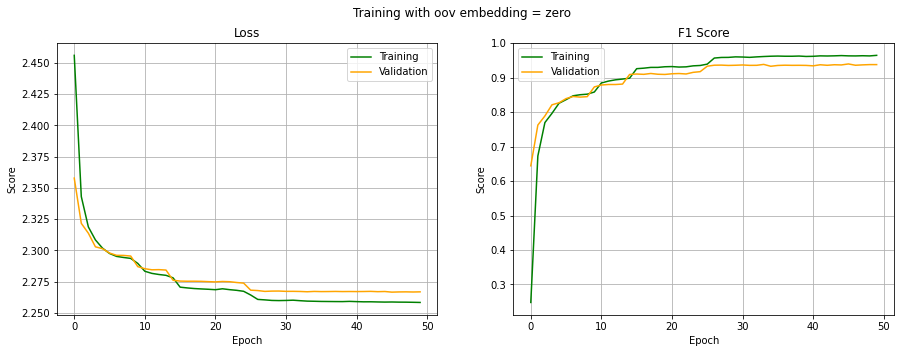

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../logs/zero/fold_{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with oov embedding = zero")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9650, device='cuda:0'),
 tensor(0.9373, device='cuda:0'),
 tensor(0.9357, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9650, device='cuda:0'),
 tensor(0.9373, device='cuda:0'),
 tensor(0.9357, device='cuda:0'))

## Heatmap

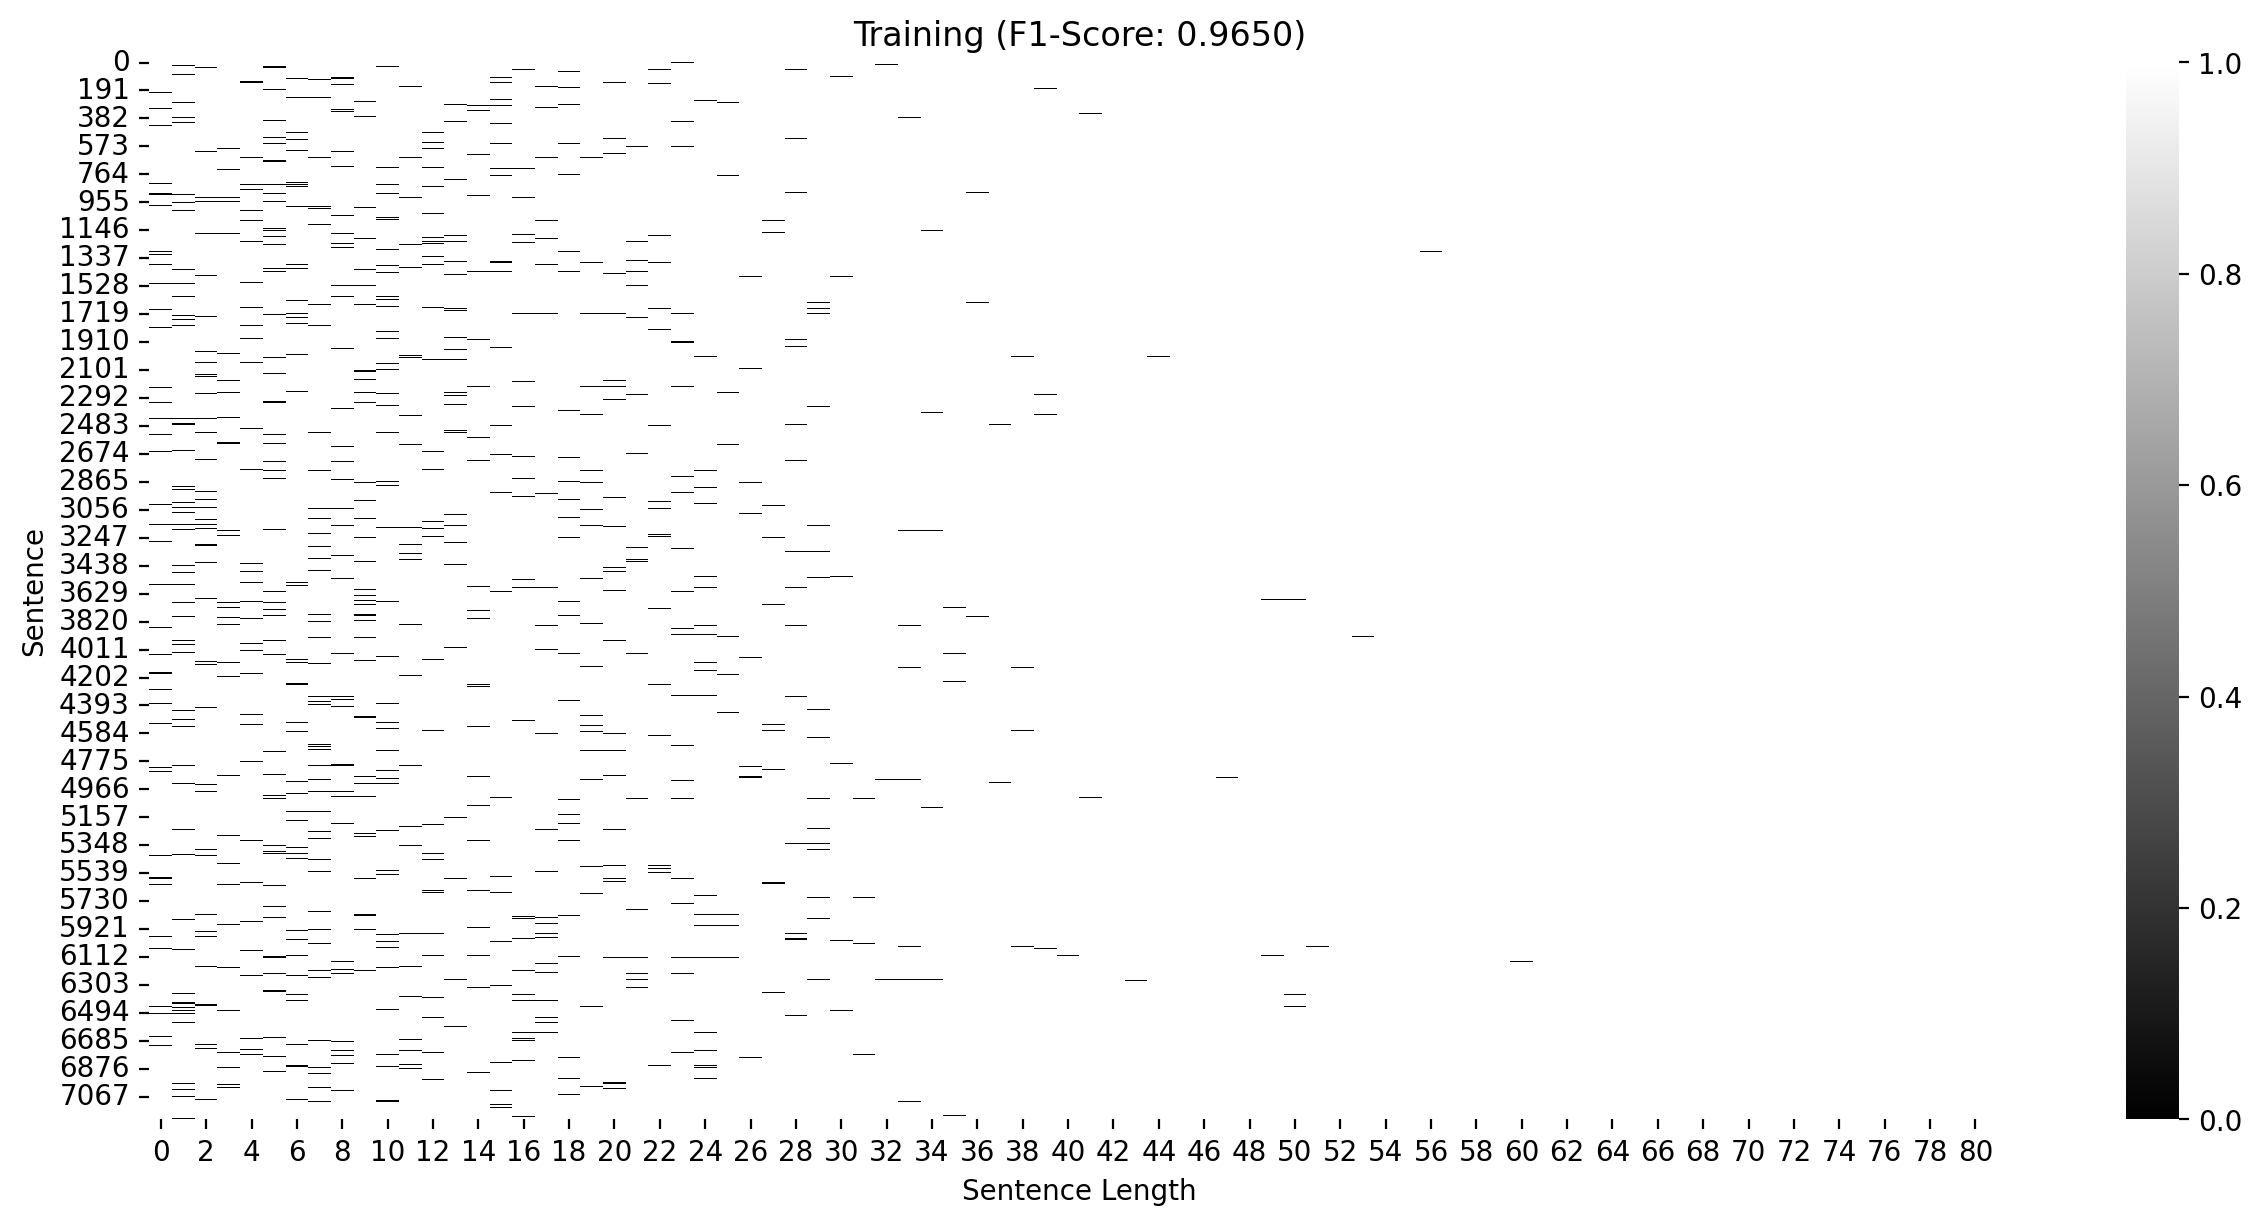

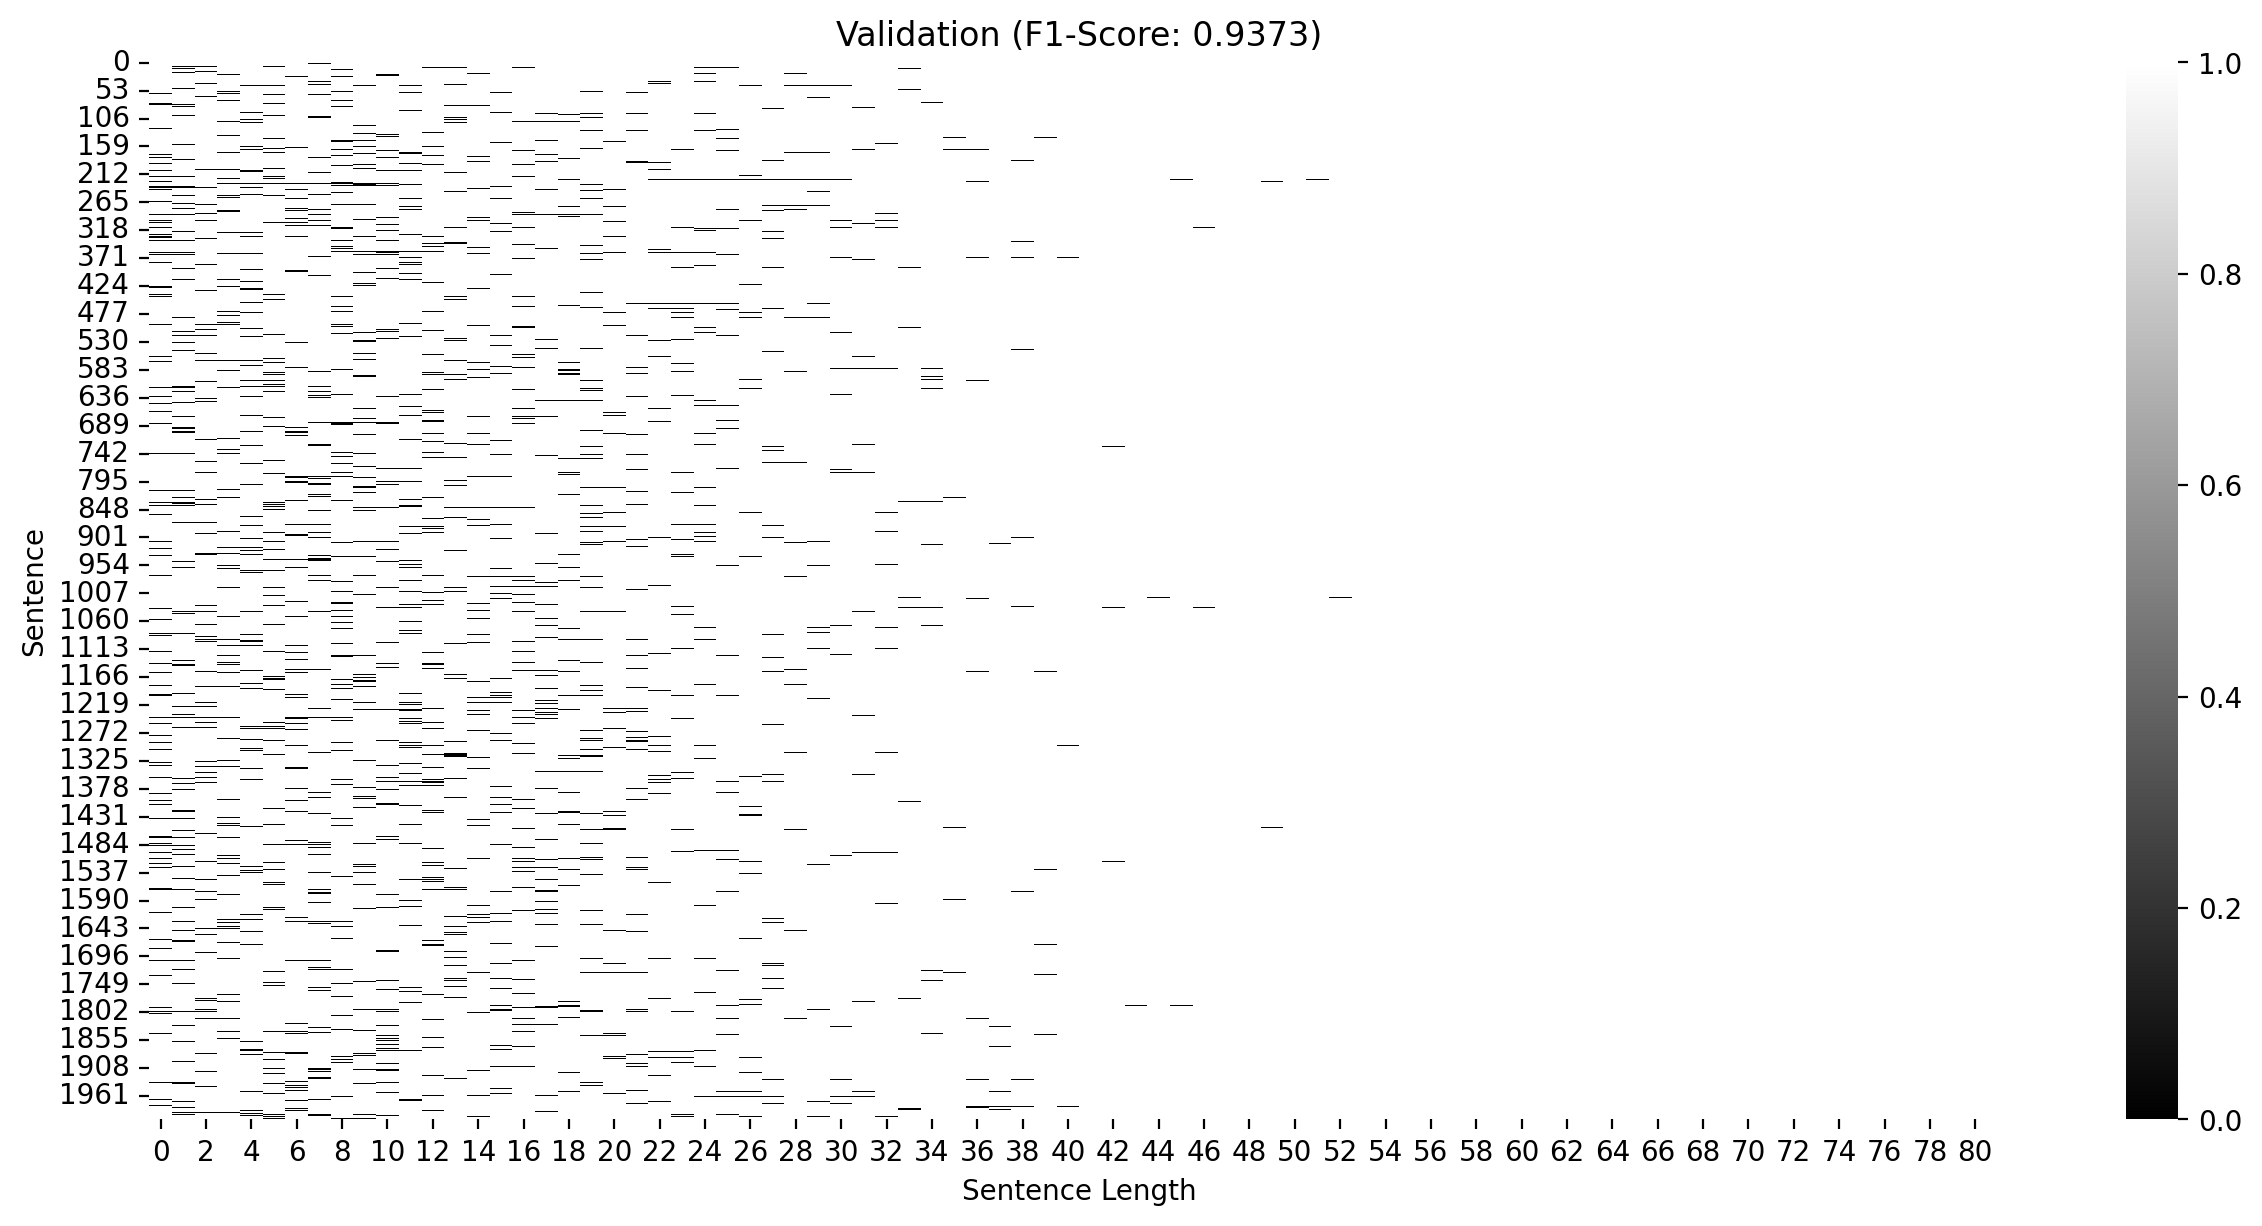

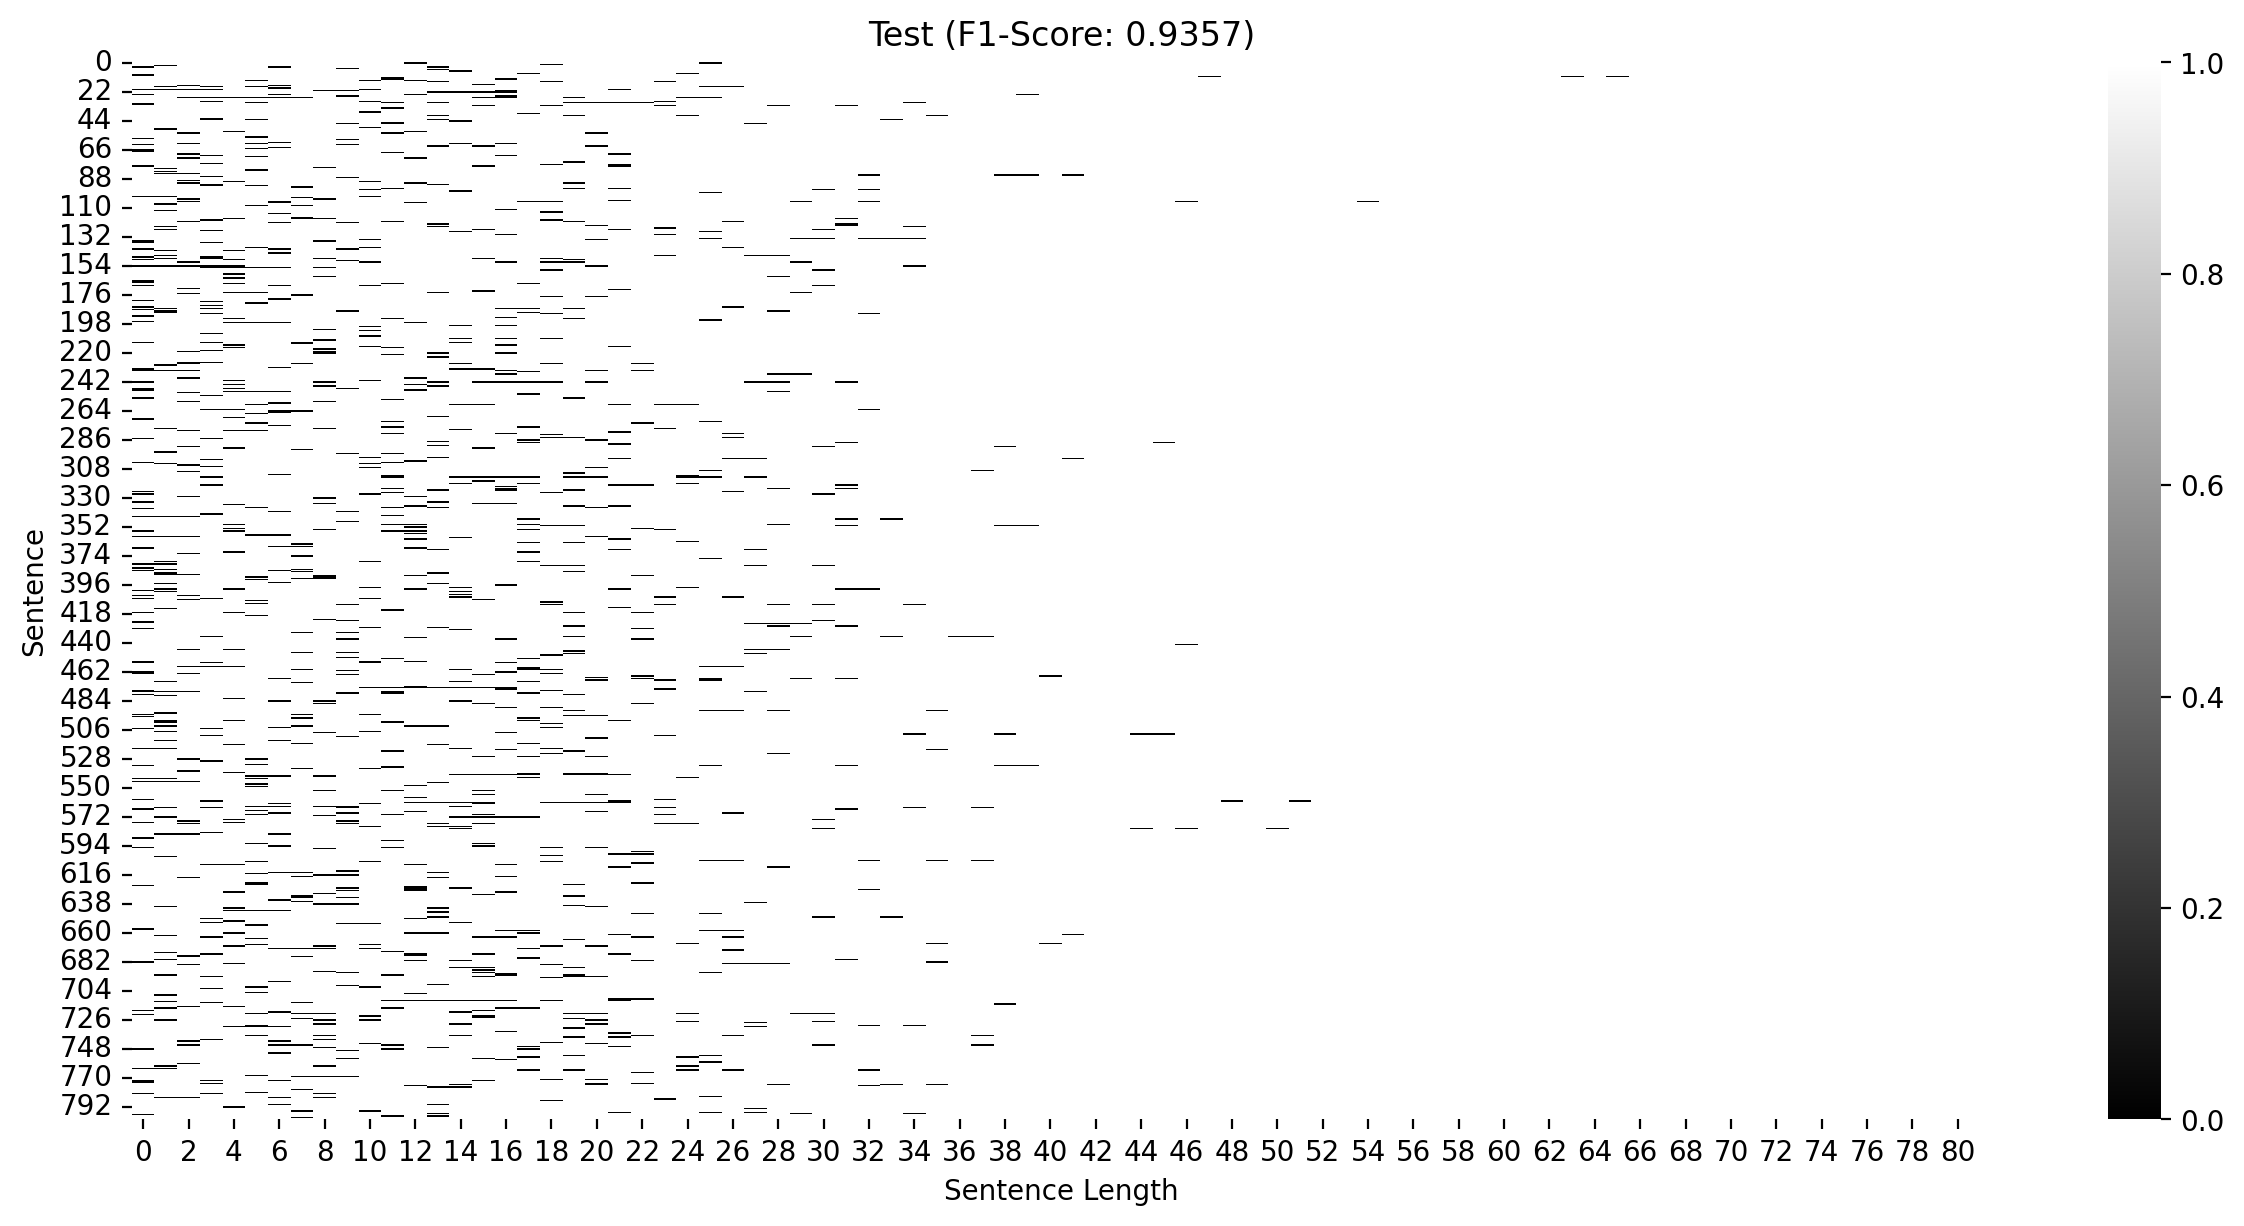

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


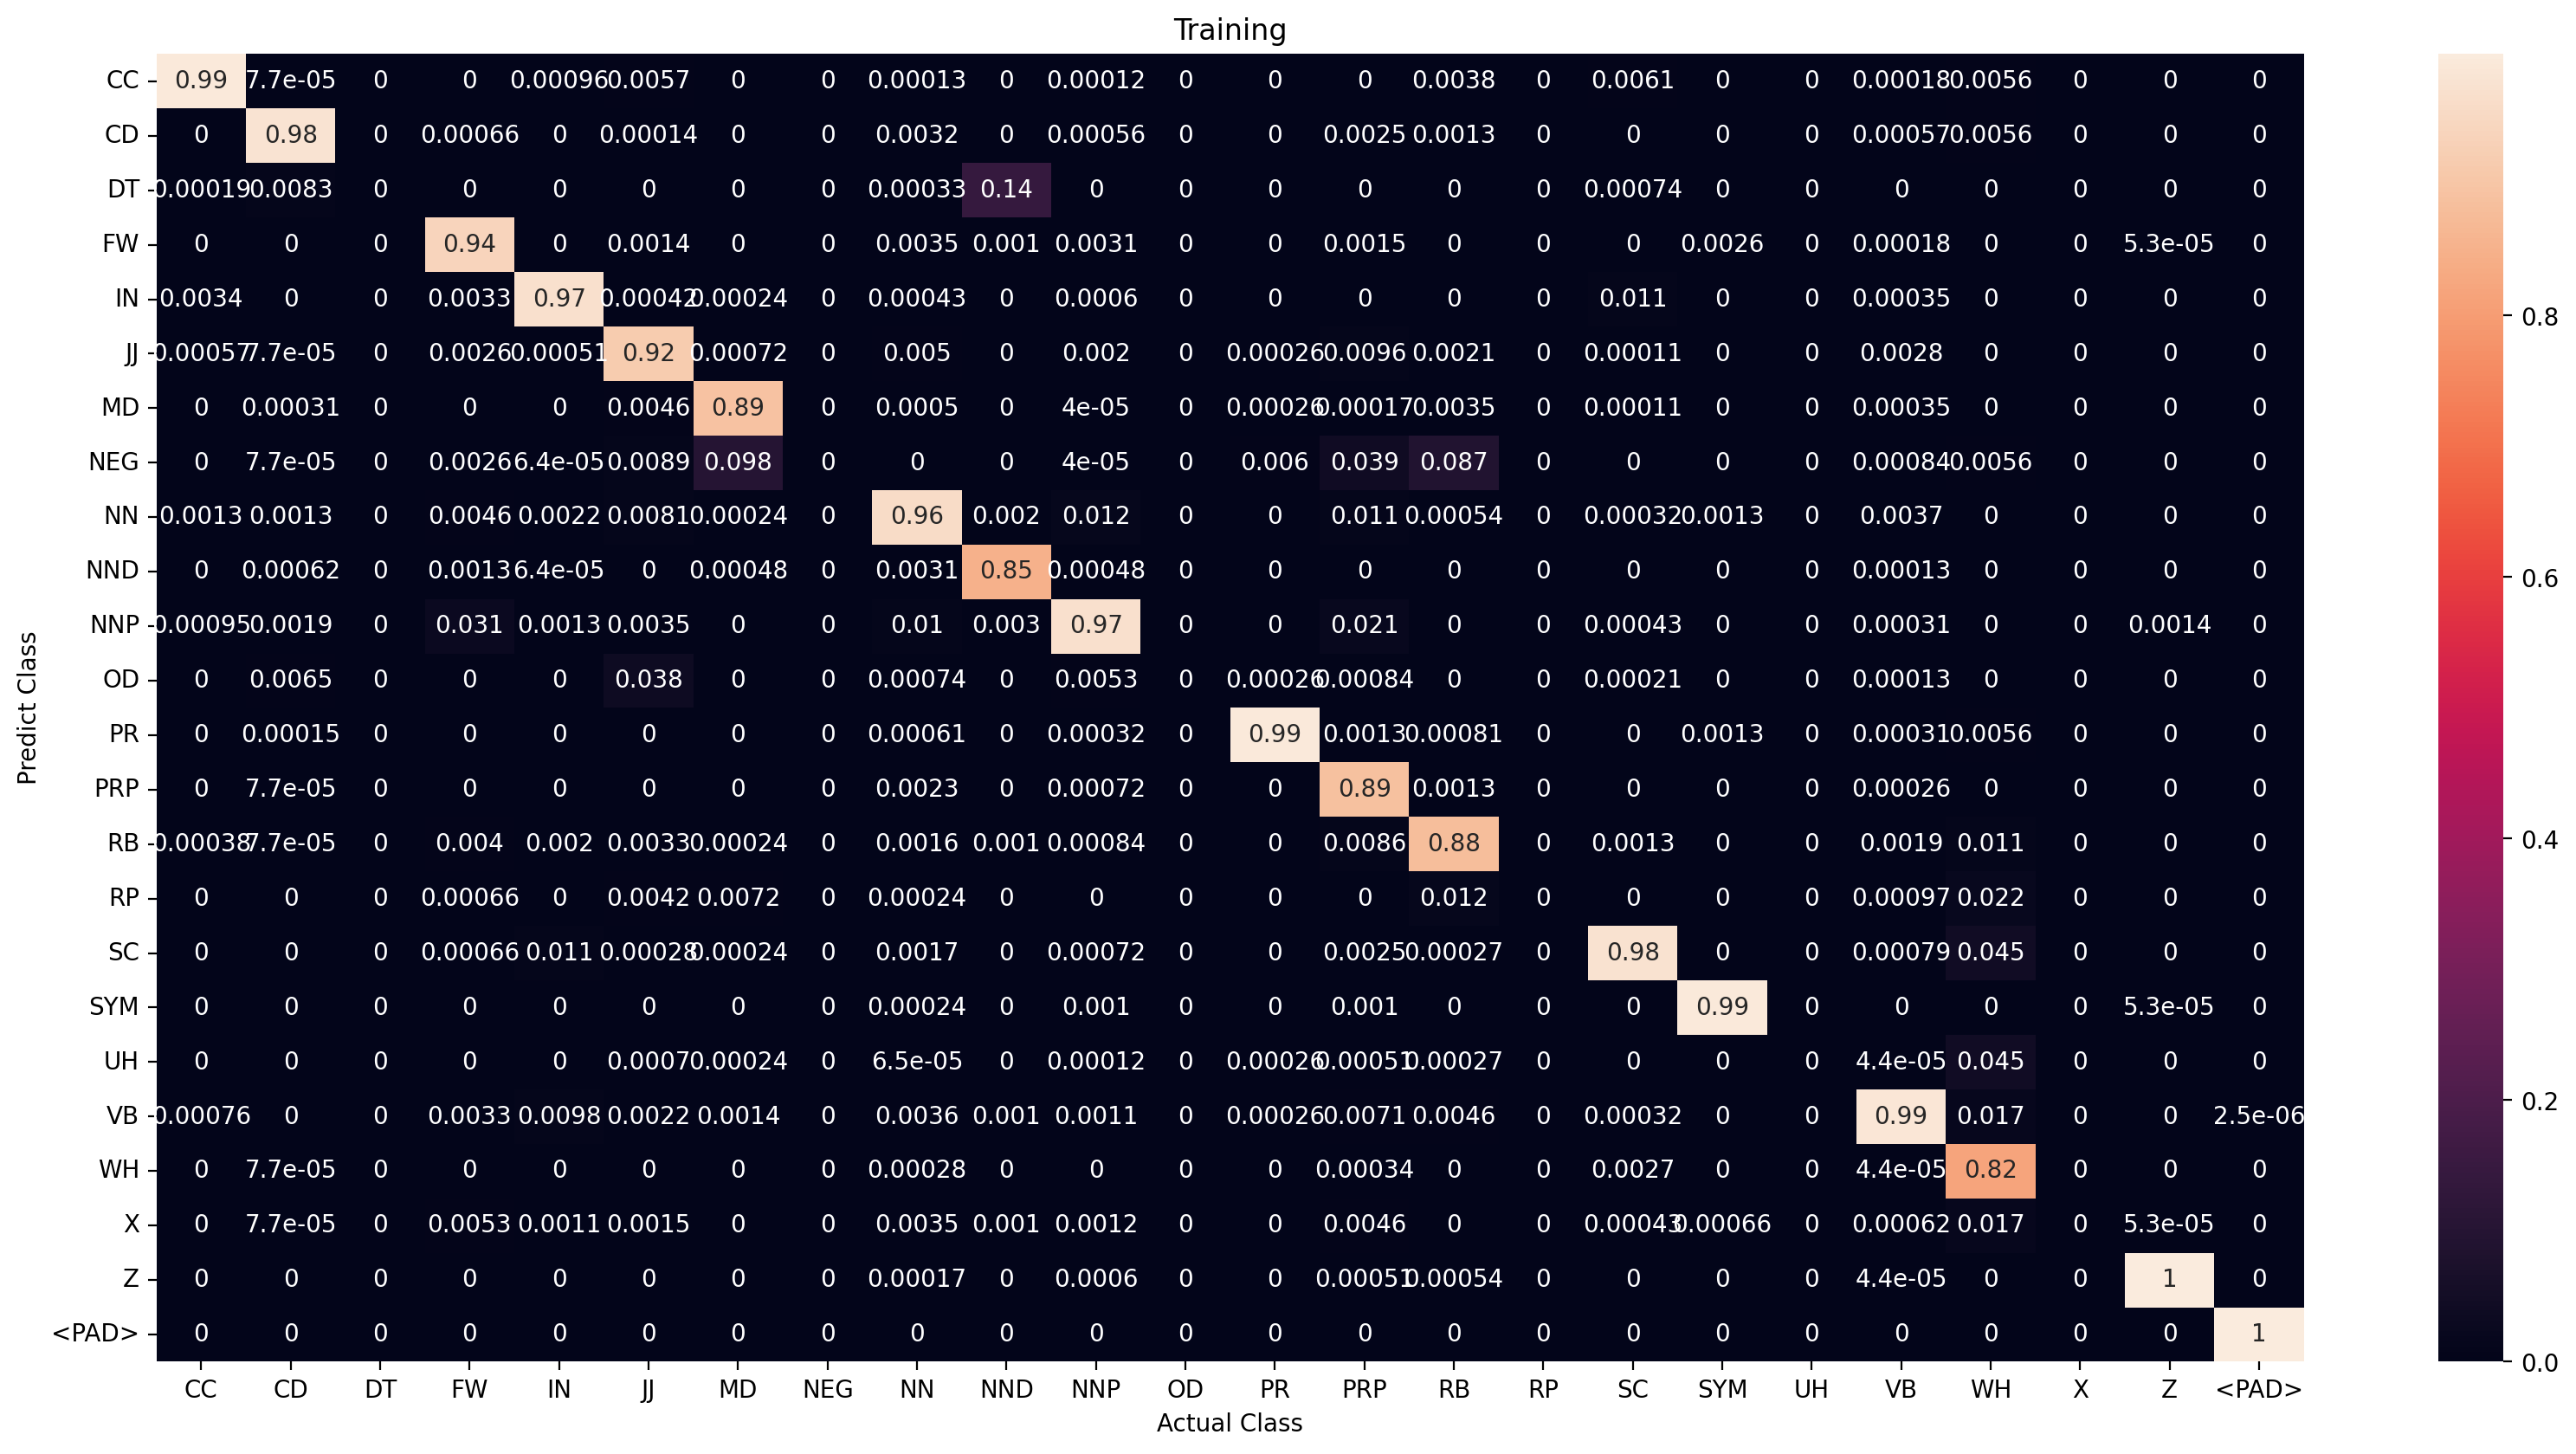

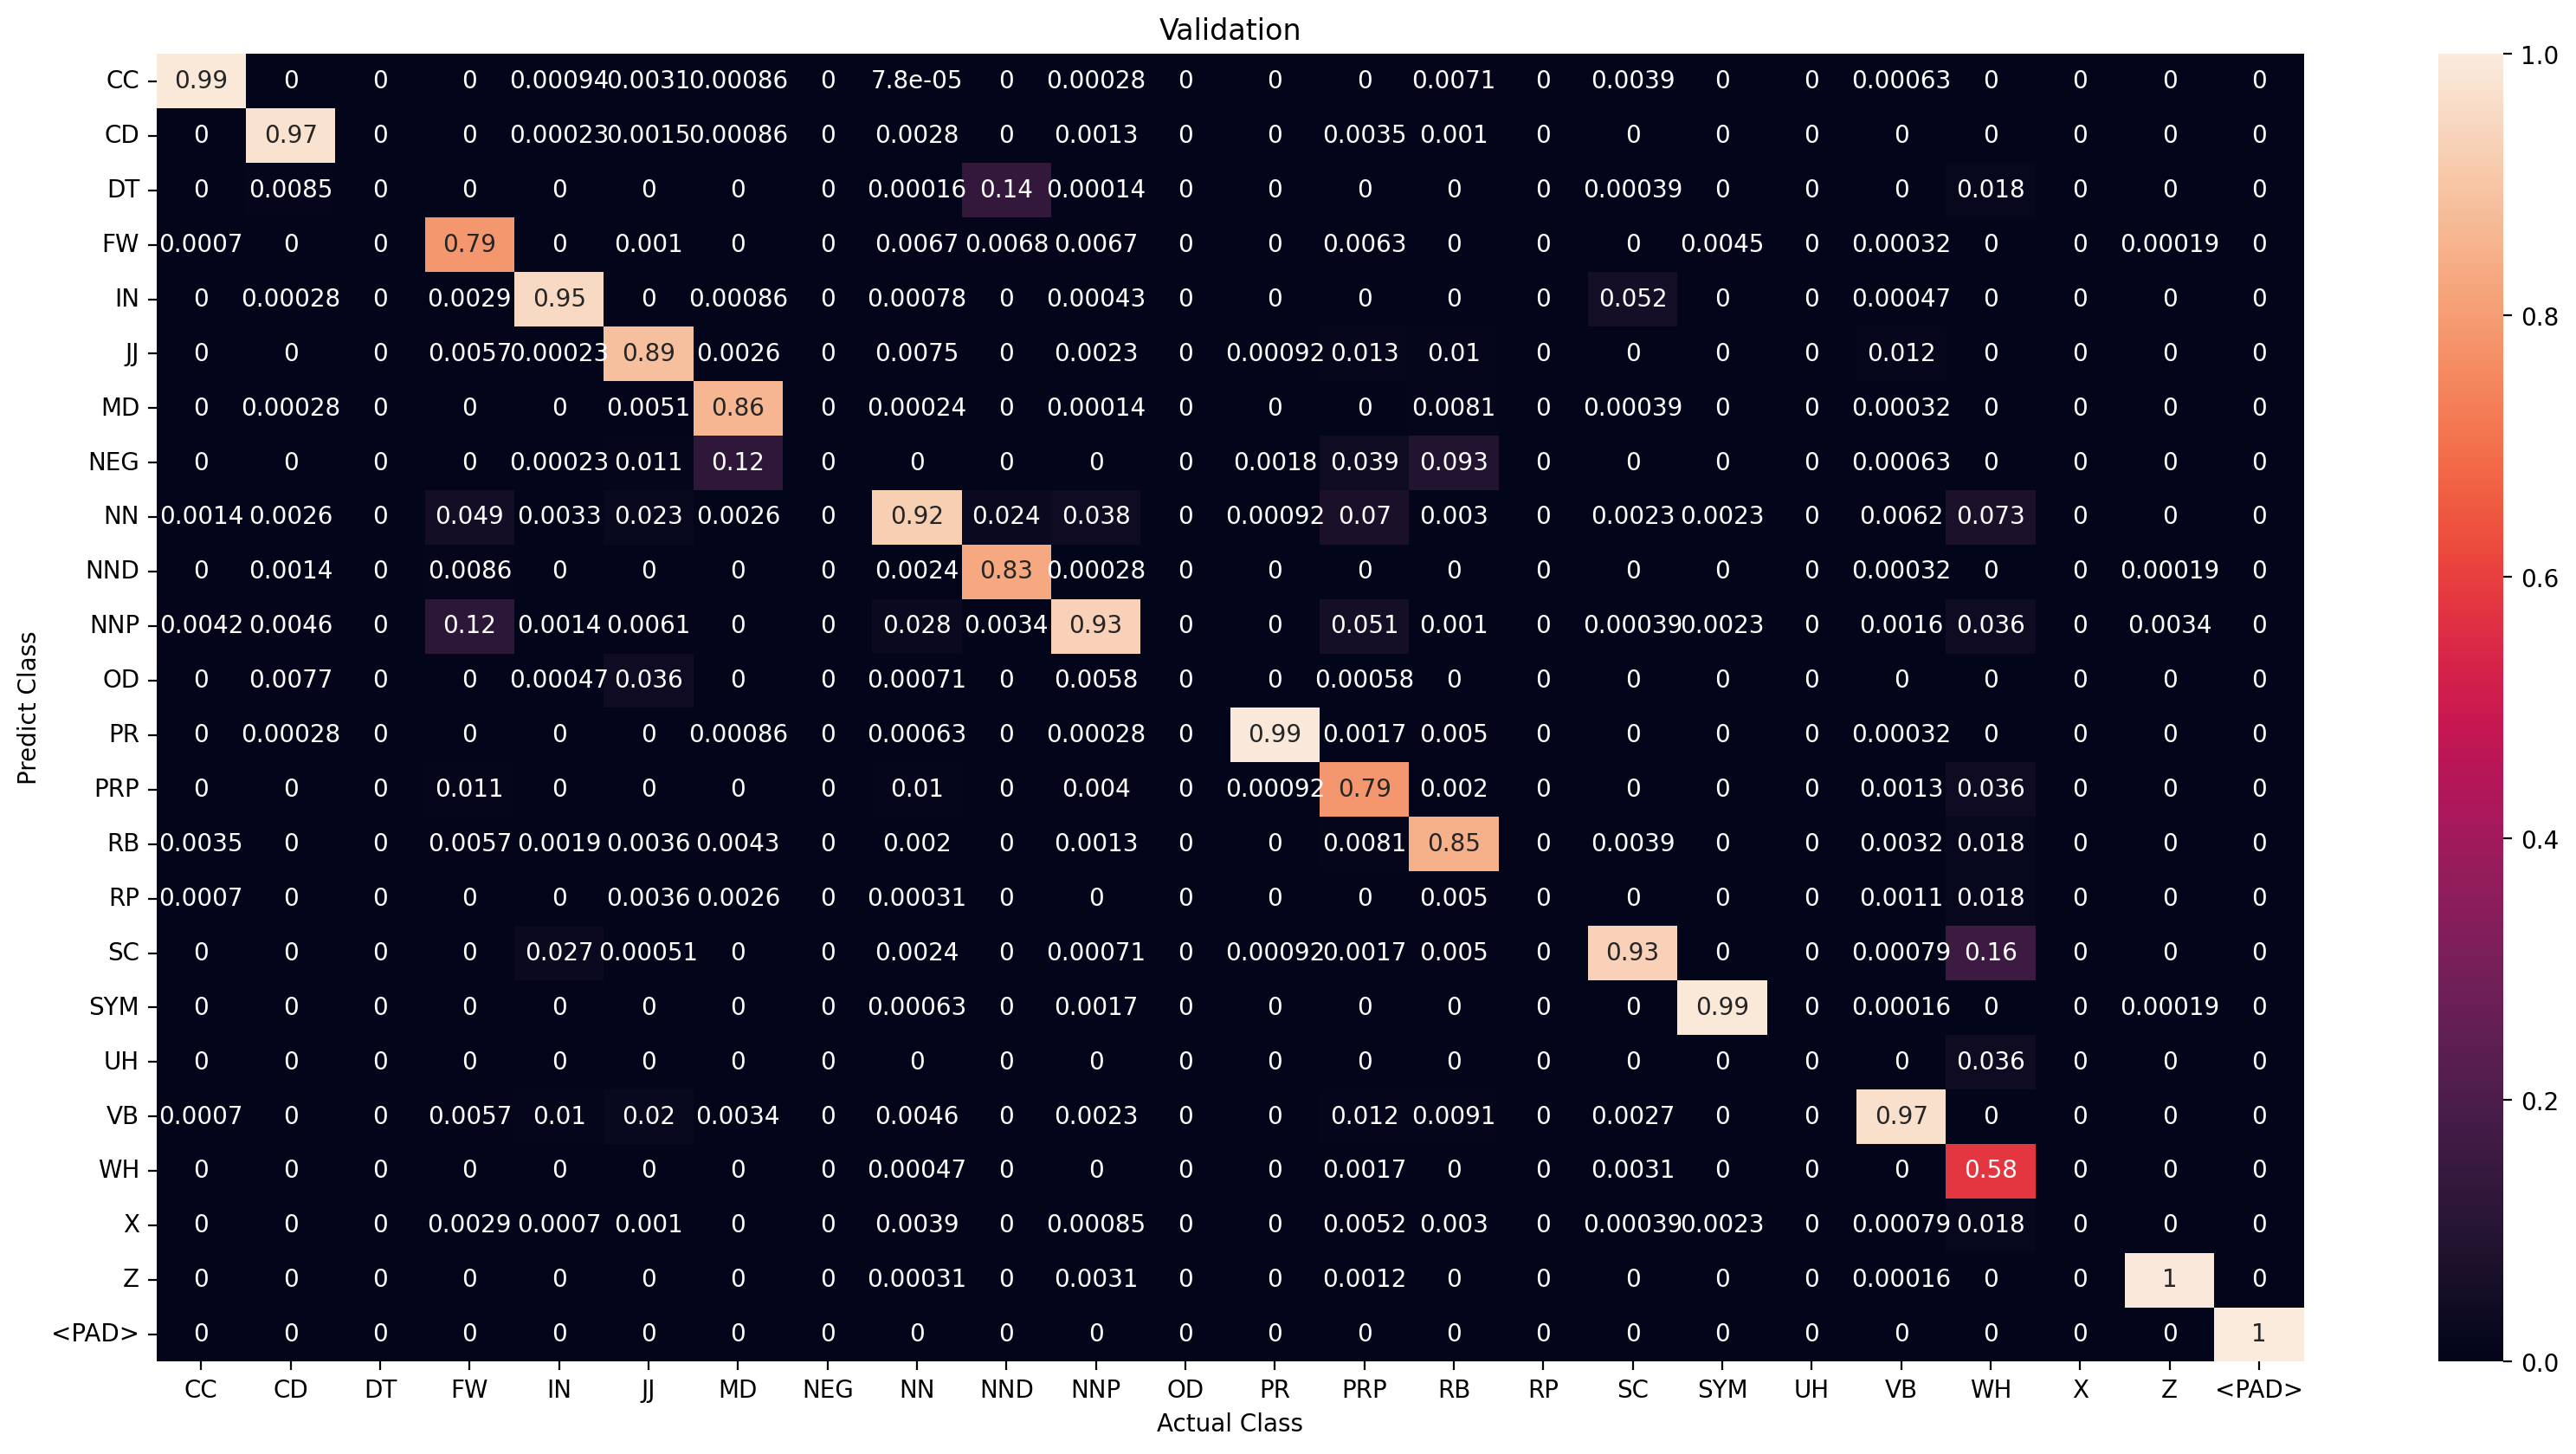

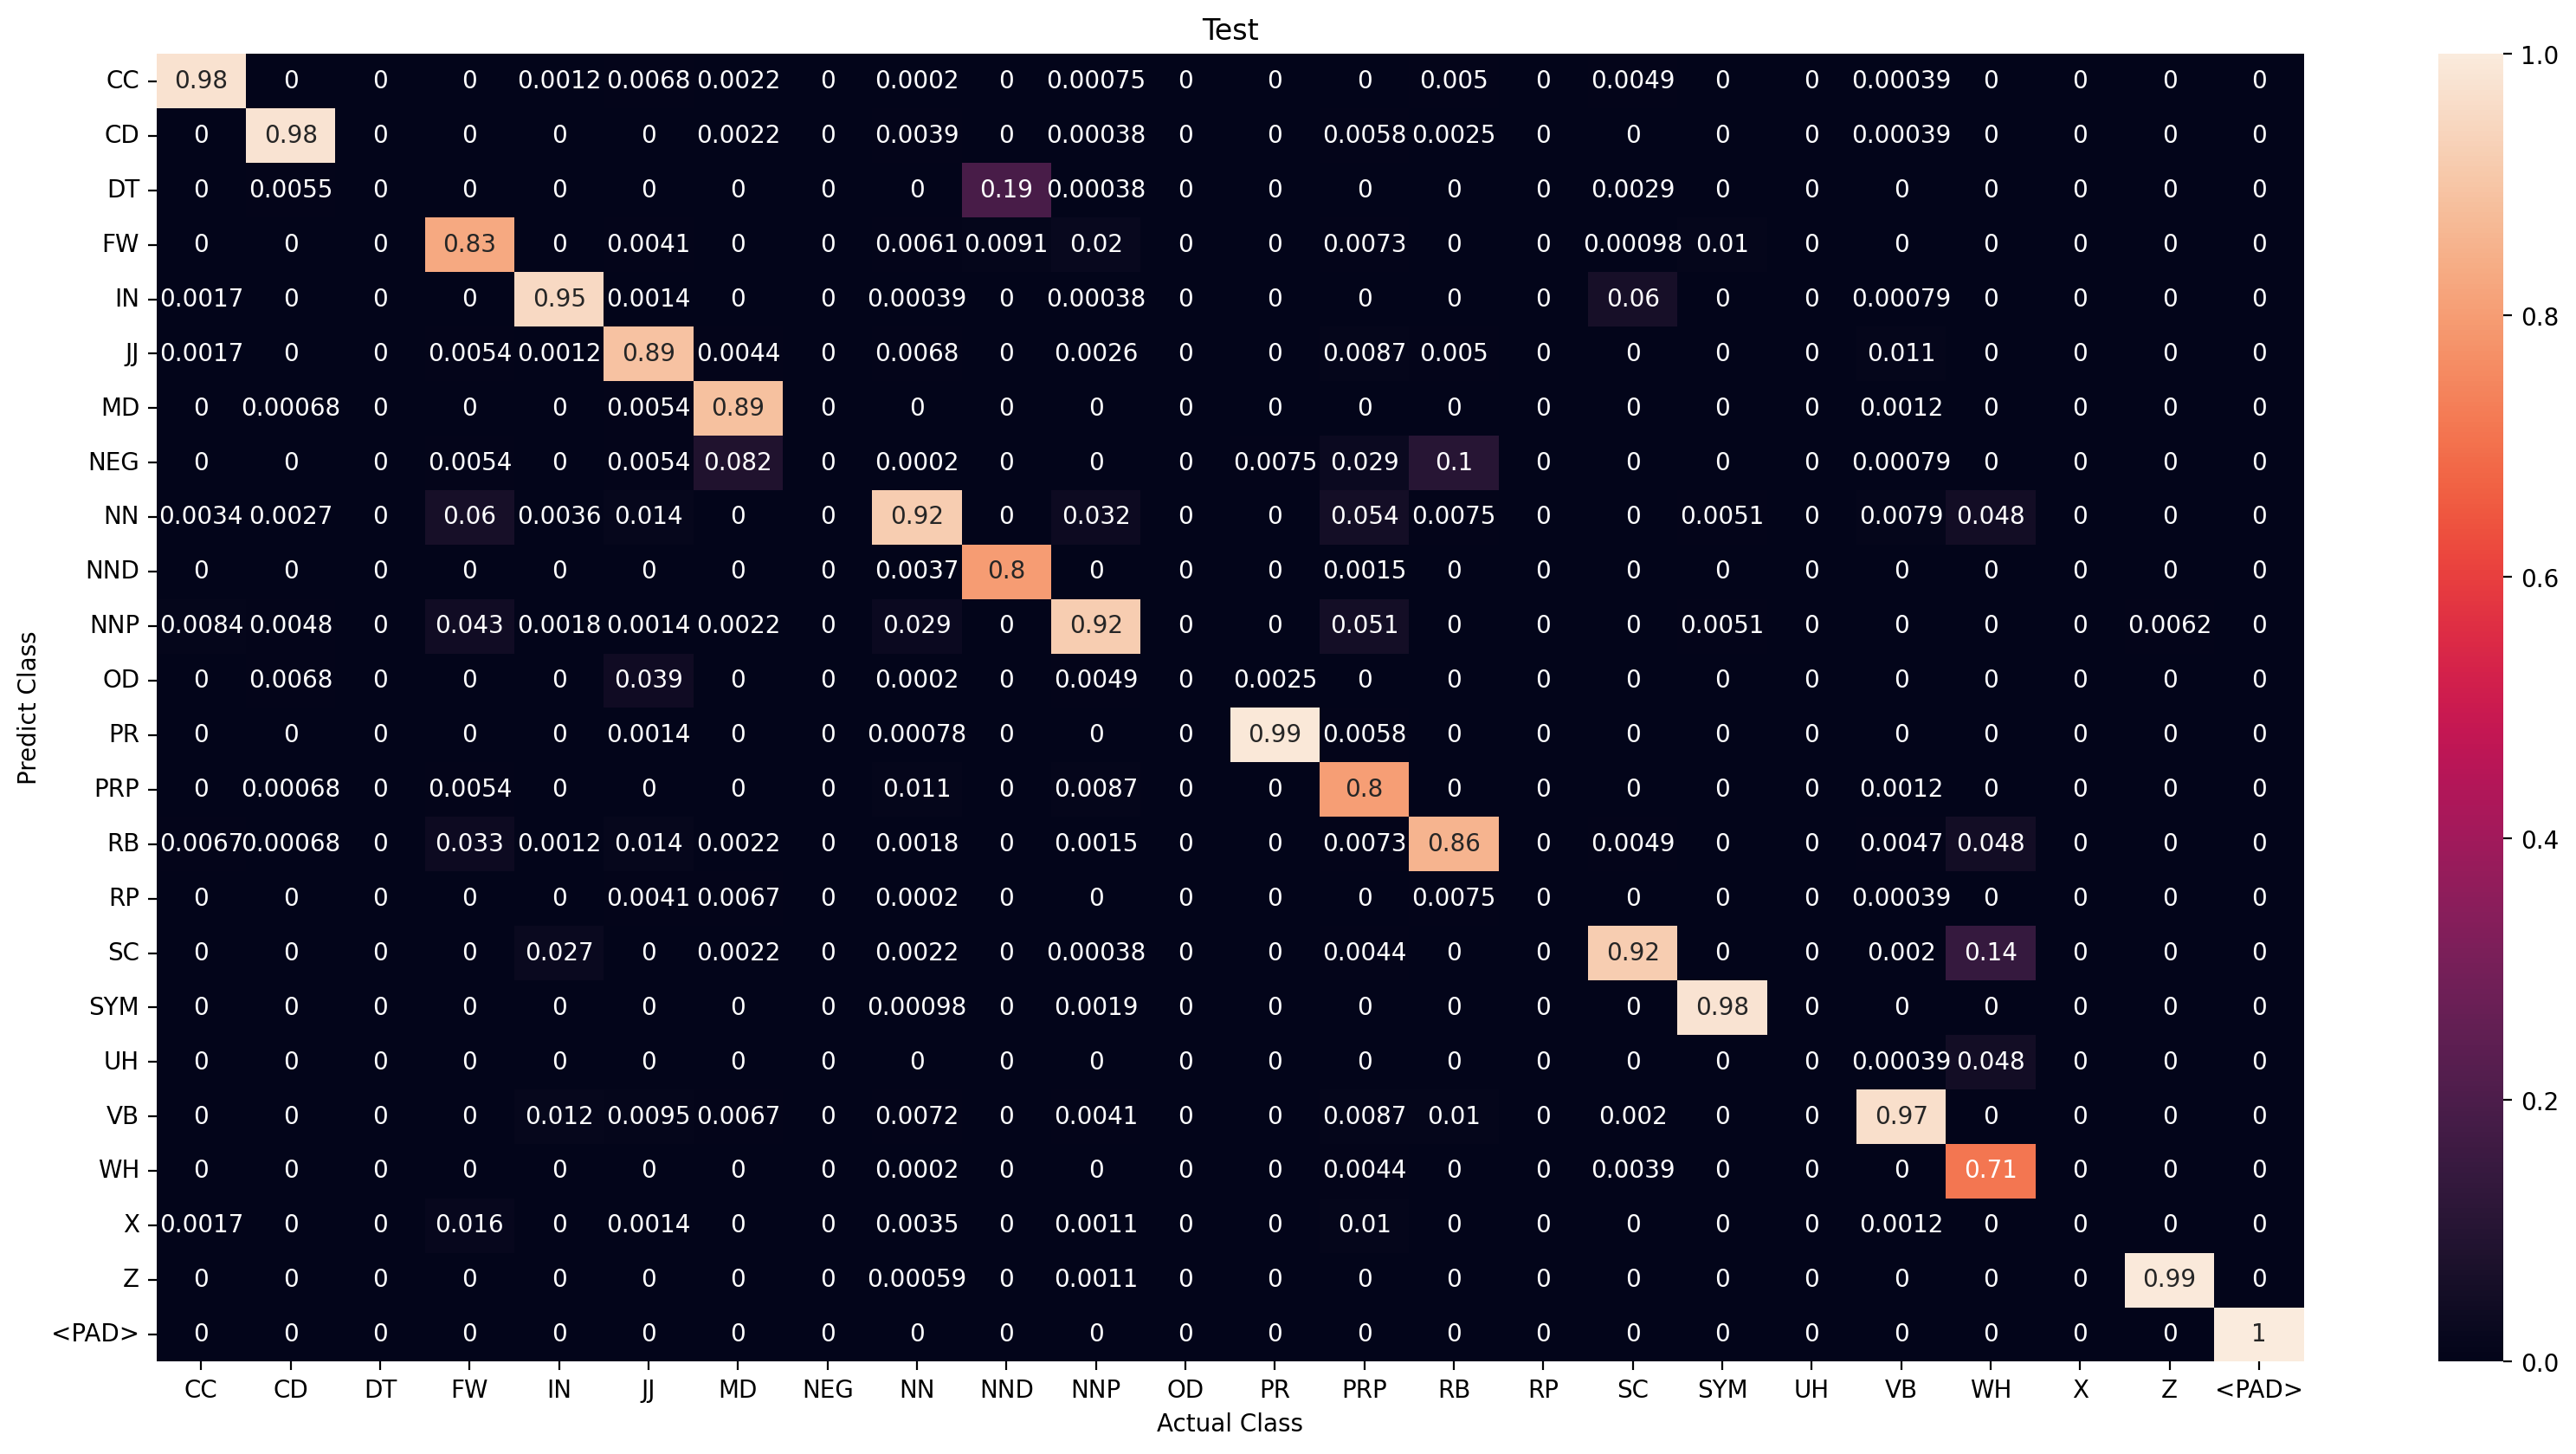

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5249       | CC    : 142      |
| CD    : 12882  | CD    : 12685      | CD    : 197      |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1423       | FW    : 267      |
| IN    : 15403  | IN    : 15229      | IN    : 174      |
| JJ    : 7018   | JJ    : 6589       | JJ    : 429      |
| MD    : 3810   | MD    : 3725       | MD    : 85       |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44139      | NN    : 589      |
| NND   : 1019   | NND   : 848        | NND   : 171      |
| NNP   : 24885  | NNP   : 24141      | NNP   : 744      |
| OD    : 534    | OD    : 0          | OD    : 534      |
| PR    : 3842   | PR    : 3783       | PR    : 59       |
| PRP   : 5405   | PRP   : 5267       | PRP   : 138      |
| RB    : 3553   | RB    : 3284       | RB    : 269      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 13,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 10248
Wrong prediction            : 1560
Percentage correct oov pred : 86.78861788617887

Validation
Number OOV token            : 3395
Correct prediction          : 2439
Wrong prediction            : 956
Percentage correct oov pred : 71.84094256259205

Test
Number OOV token            : 1359
Correct prediction          : 967
Wrong prediction            : 392
Percentage correct oov pred : 71.15526122148638



In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);